<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  

#  Gravitational Wave Open Data Workshop #3


#### Tutorial 1.2: Introduction to GWpy

This tutorial will briefly describe GWpy, a python package for gravitational astrophysics, and walk-through how you can use this to speed up access to, and processing of, GWOSC data.
    
[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2019/blob/master/Day_1/Tuto%201.2%20Open%20Data%20access%20with%20GWpy.ipynb)

<div class="alert alert-info">This notebook were generated using python 3.7, but should work on python 2.7, 3.6, or 3.7.</div>

##  Installation  (execute only if running on a cloud platform or if you haven't done the installation already!)

Note: we use [`pip`](https://docs.python.org/3.6/installing/), but **it is recommended** to use [conda](https://docs.ligo.org/lscsoft/conda/) on your own machine, as explained in the [installation instructions](https://github.com/gw-odw/odw-2019/blob/master/setup.md). This usage might look a little different than normal, simply because we want to do this directly from the notebook.

In [1]:
# -- Uncomment following line if running in Google Colab
! pip install -q 'gwpy==1.0.1'

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 2.7MB 18.6MB/s 


**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

In [2]:
import gwpy
print(gwpy.__version__)

1.0.1


## A note on object-oriented programming

Before we dive too deeply, its worth a quick aside on object-oriented programming (OOP).
GWpy is heavily object-oriented, meaning almost all of the code you run using GWpy is based around an object of some type, e.g. `TimeSeries`.
Most of the methods (functions) we will use are attached to an object, rather than standing alone, meaning you should have a pretty good idea of what sort of data you are dealing with (without having to read the documentation!).

For a quick overview of object-oriented programming in Python, see [this blog post by Jeff Knupp](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/).

## Handling data in the time domain

#### Finding open data

We have seen already that the `gwosc` module can be used to query for what data are available on GWOSC.
The next thing to do is to actually read some open data. Let's try to get some for GW150914, the first direct detection of an astrophysical gravitational-wave signal from a BBH (binary black hole system).

We can use the [`TimeSeries.fetch_open_data`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.fetch_open_data) method to download data directly from https://www.gw-openscience.org, but we need to know the GPS times.
We can query for the GPS time of an event as follows:

In [2]:
from gwosc.datasets import event_gps
gps = event_gps('GW150914')
print(gps) #in seconds

1126259462.4


Now we can build a `[start, end)` GPS segment to 10 seconds around this time, using integers for convenience:

In [4]:
segment = (int(gps)-5, int(gps)+5)
print(segment)

(1126259457, 1126259467)


and can now query for the full data.
For this example we choose to retrieve data for the LIGO-Livingston interferometer, using the identifier `'L1'`.
We could have chosen any of

- `'G1`' - GEO600
- `'H1'` - LIGO-Hanford
- `'L1'` - LIGO-Livingston
- `'V1'` - (Advanced) Virgo

In the future, the Japanese observatory KAGRA will come online, with the identifier `'K1'`.

In [5]:
from gwpy.timeseries import TimeSeries
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True)
print(ldata)

Fetched 1 URLs from www.gw-openscience.org for [1126259457 .. 1126259467))
Reading data... [Done]
TimeSeries([-9.31087178e-19, -9.75697062e-19, -1.01074940e-18,
            ..., -1.13460681e-18, -1.11414494e-18,
            -1.15931435e-18]
           unit: dimensionless,
           t0: 1126259457.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


##### The `verbose=True` flag lets us see that GWpy has discovered two files that provides the data for the given interval, downloaded them, and loaded the data.
The files are not stored permanently, so next time you do the same call, it will be downloaded again, however, if you know you might repeat the same call many times, you can use `cache=True` to store the file on your computer.

Notes: 

* To read data from a local file instead of from the GWOSC server, we can use [`TimeSeries.read`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.read) method.

We have now downloaded real LIGO data for GW150914! These are the actual data used in the analysis that discovered the first binary black hole merger.

To sanity check things, we can easily make a plot, using the [`plot()`](https://gwpy.github.io/docs/stable/timeseries/plot.html) method of the `data` `TimeSeries`.

<div class="alert alert-info">
Since this is the first time we are plotting something in this notebook, we need to make configure `matplotlib` (the plotting library) to work within the notebook properly:
</div>

Matplotlib documentation can be found [`here`](https://matplotlib.org/contents.html).

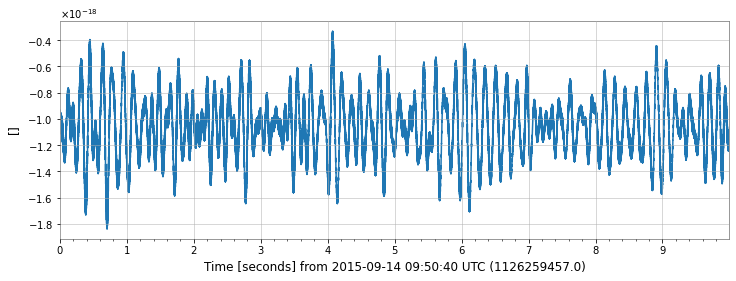

In [7]:
%matplotlib inline
plot = ldata.plot()

Notes: There are alternatives ways to access the GWOSC data. 

* [`readligo`](https://losc.ligo.org/s/sample_code/readligo.py) is a light-weight Python module that returns the time series into a Numpy array.
* The [PyCBC](http://github.com/ligo-cbc/pycbc) package has the `pycbc.frame.query_and_read_frame` and `pycbc.frame.read_frame` methods. We use [PyCBC](http://github.com/ligo-cbc/pycbc) in Tutorial 2.1, 2.2 and 2.3. 

## Handling data in the frequency domain using the Fourier transform

The [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) is a widely-used mathematical tool to expose the frequency-domain content of a time-domain signal, meaning we can see which frequencies contian lots of power, and which have less.

We can calculate the Fourier transform of our `TimeSeries` using the [`fft()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.fft) method:

In [8]:
fft = ldata.fft() #this calculates
print(fft)

FrequencySeries([-1.05219333e-18+0.00000000e+00j,
                 -9.36314427e-22+6.61514979e-23j,
                 -8.74693847e-22-3.26717194e-23j, ...,
                  6.63325463e-24-1.10870240e-26j,
                  6.73663868e-24-7.82178218e-26j,
                  6.69598891e-24+0.00000000e+00j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.1 Hz,
                epoch: 1126259457.0,
                name: Strain,
                channel: None)


The result is a [`FrequencySeries`](https://gwpy.github.io/docs/stable/frequencyseries/), with complex amplitude, representing the amplitude and phase of each frequency in our data.
We can use `abs()` to extract the amplitude and plot that:

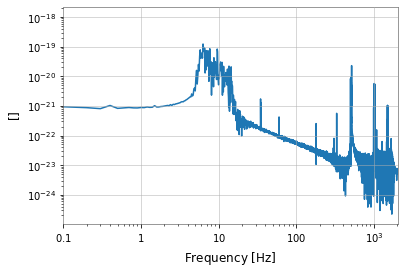

In [9]:
plot = fft.abs().plot(xscale="log", yscale="log")
plot.show(warn=False) #at higher frequencies, it's discontinuous?

This doesn't look correct at all!
The problem is that the FFT works under the assumption that our data are periodic, which means that the edges of our data look like discontinuities when transformed.
We need to apply a window function to our time-domain data before transforming, which we can do using the [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/signal.html) module:

In [0]:
from scipy.signal import get_window
window = get_window('hann', ldata.size) #what is this? 
lwin = ldata * window

Let's try our transform again and see what we get

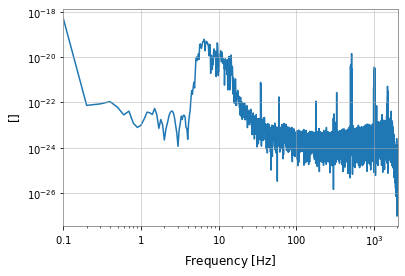

In [12]:
fftamp = lwin.fft().abs()
plot = fftamp.plot(xscale="log", yscale="log")
plot.show(warn=False) #y-axis units?

This looks a little more like what we expect for the amplitude spectral density of a gravitational-wave detector.

## Calculating the power spectral density

In practice, we typically use a large number of FFTs to estimate an averages power spectral density over a long period of data.
We can do this using the [`asd()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.asd) method, which uses [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method) to combine FFTs of overlapping, windowed chunks of data.

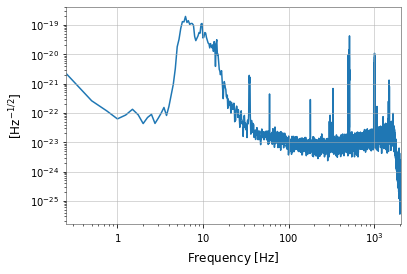

In [23]:
asd = ldata.asd(fftlength=4, method="median") # fftlength=number of seconds in single FFTs. Must be < window shape
plot = asd.plot()
plot.show(warn=False)

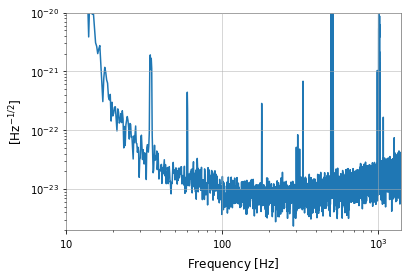

In [24]:
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(2e-24, 1e-20)
plot

The ASD is a standard tool used to study the frequency-domain sensitivity of a gravitational-wave detector.
For the LIGO-Livingston data we loaded, we can see large spikes at certain frequencies, including

- ~300 Hz
- ~500 Hz
- ~1000 Hz

The [O2 spectral lines](https://www.gw-openscience.org/o2speclines/) page on GWOSC describes a number of these spectral features for O2, with some of them being forced upon us, and some being deliberately introduced to help with interferometer control.

Loading more data allows for more FFTs to be averaged during the ASD calculation, meaning random variations get averaged out, and we can see more detail:

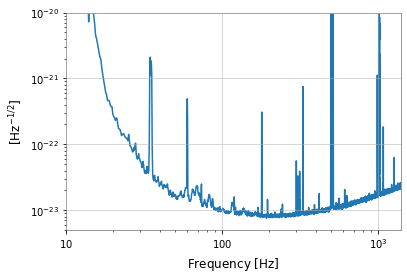

In [25]:
ldata2 = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method="median")
plot = lasd2.plot()
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(5e-24, 1e-20)
plot.show(warn=False)

Now we can see some more features, including sets of lines around ~30 Hz and ~65 Hz, and some more isolate lines through the more sensitive region.

For comparison, we can load the LIGO-Hanford data and plot that as well:

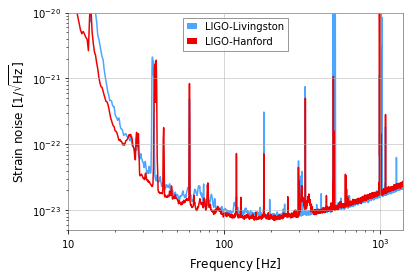

In [26]:
# get Hanford data
hdata2 = TimeSeries.fetch_open_data('H1', int(gps)-512, int(gps)+512, cache=True)
hasd2 = hdata2.asd(fftlength=4, method="median")

# and plot using standard colours
ax.plot(hasd2, label='LIGO-Hanford', color='gwpy:ligo-hanford')

# update the Livingston line to use standard colour, and have a label
lline = ax.lines[0]
lline.set_color('gwpy:ligo-livingston')  # change colour of Livingston data
lline.set_label('LIGO-Livingston')

ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax.legend()
plot

Now we can see clearly the relative sensitivity of each LIGO instrument, the common features between both, and those unique to each observatory.

# Challenges:

##### Quiz Question 1:

The peak amplitude in the LIGO-Livingston data occurs at approximately 5 seconds into the plot above and is undetectable above the background noise by the eye. Plot the data for the LIGO-Hanford detector around GW150914. Looking at your new LIGO-Handford plot, can your eye identify a signal peak? 

In [29]:
from gwosc.datasets import event_gps
gps = event_gps('GW150914')
print(gps) #in seconds

1126259462.4


In [30]:
segment = (int(gps)-5, int(gps)+5)
print(segment)

(1126259457, 1126259467)


In [31]:
#Plot the data for the LIGO-Hanford detector around GW150914
from gwpy.timeseries import TimeSeries
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True)
print(hdata)


Fetched 1 URLs from www.gw-openscience.org for [1126259457 .. 1126259467))
Reading data... [Done]
TimeSeries([-3.37408113e-19, -3.60538427e-19, -3.22327735e-19,
            ...,  1.52206625e-19,  1.58897479e-19,
             1.71197631e-19]
           unit: dimensionless,
           t0: 1126259457.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


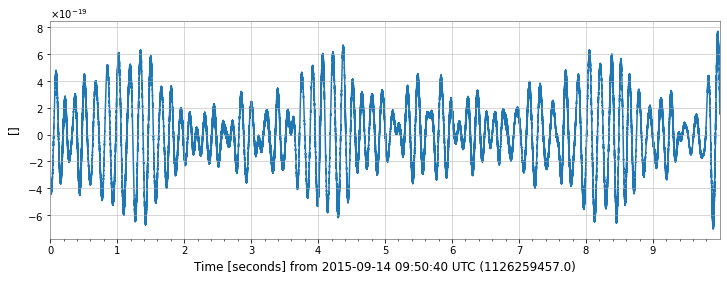

In [32]:
%matplotlib inline
plot = hdata.plot()

# Quiz Question 2 :

Make an ASD around the time of an O3 event, GW190412 for L1 detector .  Compare this with the ASDs around GW150914 for L1 detector.  Which data have lower noise - and so are more sensitive - around 100 Hz?


In [56]:
#getting gps
from gwosc.datasets import event_gps
gps = event_gps('GW190412')
print(gps) #in seconds

#integers
segment2 = (int(gps)-5, int(gps)+5)
print(segment2)

1239082262.2
(1239082257, 1239082267)


Fetched 1 URLs from www.gw-openscience.org for [1239082257 .. 1239082267))
Reading data... [Done]


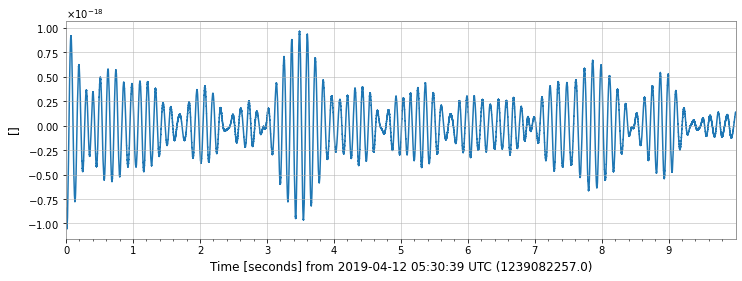

In [39]:
#plotting livingston data in time domain
from gwpy.timeseries import TimeSeries
l2data = TimeSeries.fetch_open_data('L1', *segment, verbose=True)
#print(l2data)
%matplotlib inline
plot = l2data.plot()

In [41]:
#calculating FFT
fft2 = l2data.fft() 
print(fft2)

FrequencySeries([-1.45894410e-21+0.00000000e+00j,
                 -2.91834926e-21-4.52905658e-23j,
                 -2.91973330e-21-9.06202944e-23j, ...,
                 -2.38723982e-23+4.67871180e-26j,
                 -2.38345362e-23+1.80394054e-26j,
                 -2.38457175e-23+0.00000000e+00j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.1 Hz,
                epoch: 1239082257.0,
                name: Strain,
                channel: None)


In [0]:
#adding window
from scipy.signal import get_window
window2 = get_window('hann', l2data.size) #hann is a window formed by using a raised cosine or sine-squared with ends that touch zero.
l2win = l2data * window2

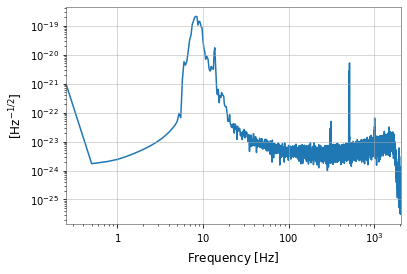

In [49]:
#plotting ASD
fftamp = l2win.fft().abs()
plot = fftamp.plot(xscale="log", yscale="log")
#plot.show(warn=False) #y-axis units?

#averaging?
asd = l2data.asd(fftlength=4, method="median") # fftlength=number of seconds in single FFTs. Must be < window shape
plot = asd.plot()
plot.show(warn=False)

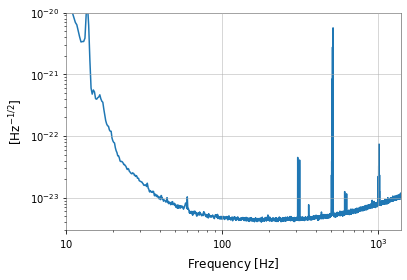

In [70]:
#zooming in 
l2data2 = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
l2asd2 = l2data2.asd(fftlength=4, method="median")
plot = l2asd2.plot()
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(3e-24, 1e-20)
plot.show(warn=False)

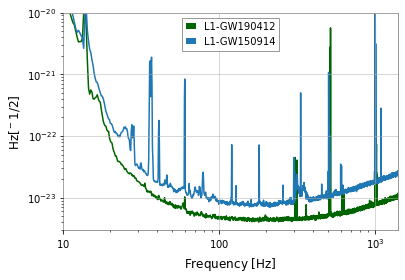

In [71]:
# Livingston data for GW150914
l4data2 = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
l4asd2 = l4data2.asd(fftlength=4, method="median")

# and plot using standard colours
ax.plot(hasd2, label='L1-GW150914', color='C0')

# update the Livingston color/label for GW190412
l2line = ax.lines[0]
l2line.set_color('darkgreen')  # change colour of Livingston data
l2line.set_label('L1-GW190412')

ax.set_ylabel(r'Hz[$^-1/2$]')
ax.legend()
plot